# NLP Model to Analyze Twitter Sentiment 

Objective of this project is to perform supervised sentiment analysis on Twitter tweets about Google and <br>Apple products using Natural Language Processing(NLP) model, so the model can rate the sentiment of a <br>Tweet based on its content. 

# Importing the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from matplotlib import cm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import string, re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data

Obtained the dataset from CrowdFlower  <br> Source: https://www.crowdflower.com/data-for-everyone/

In [2]:
#loading the data into dataframe using pandas
df= pd.read_csv('judge-1377884607_tweet_product_company.csv',  encoding= 'unicode_escape')

In [3]:
#printing the first five rows of dataframe
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#checking the datatype of columns in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


This dataframe has records over 9000 tweets and  has 3 columns tweet_text, emotion_in_tweet_is_directed_at <br> and is_there_an_emotion_directed_at_a_brand_or_product.
Renaming the column names since they are really long.

In [5]:
# Rename columns with really long names
df.columns = ['tweet_text', 'emotion_directed_at', 'emotion']

In [6]:
#printing the first five rows of dataframe after renaming the column
df.head()

,tweet_text,emotion_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# EDA and Data Visualizations

In [7]:
#checking for the null values
df.isna().sum()

tweet_text                1
emotion_directed_at    5802
emotion                   0
dtype: int64

In [8]:
#dropping the row with nullvalue in tweet_text
df.dropna(subset = ['tweet_text'], inplace = True)

In [9]:
#checking for the null values
df.isna().sum()

tweet_text                0
emotion_directed_at    5801
emotion                   0
dtype: int64

In [10]:
#checking the value counts
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

The problem that noticed first is that the our target variable, "emotion_directed_at_brand", includes many values <br>that are "No emotion toward brand or product" and few values of "i can't tell". So decided to drop<br>the rows with "i can't tell' and replacing "No emotion toward brand or product" with "Neutral emotion".

In [11]:
#dropping the rows with emotion (i can't tell)
df.drop(df[df['emotion'] == 'I can\'t tell'].index, inplace = True)

In [12]:
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

Renaming the 'emotion' column values  'No emotion toward brand or product' with 'Neutral emotion' to build <br>a multiclass classifier.

In [13]:
#replacing the emotion(No emotion toward brand or peoduct) with Neutral emotion
df['emotion'] = df['emotion'].replace({'No emotion toward brand or product': 
                         'Neutral emotion'})

In [14]:
#Now there is three classes 
df['emotion'].value_counts()

Neutral emotion     5388
Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [15]:
#checking the values of brand or product
df['emotion_directed_at'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_directed_at, dtype: int64

**Creating a column for company in dataframe** <br>
The function to separate the Apple and Google product or services and create column 'company'.

In [16]:
#fuction to separate Apple and Google products
def get_company(row):
    list = ['iPad','Apple','iPad or iPhone App','iPhone','Other Apple product or service']
    if row['emotion_directed_at'] is np.nan:
        return np.nan
    if row['emotion_directed_at'] in list:
        return 'Apple'
    else:
        return 'Google'

In [17]:
#creating the column company in dataframe
df['company'] = df.apply(get_company, axis = 1)

In [18]:
#printing the 5 rows of dataframe
df.head()

,tweet_text,emotion_directed_at,emotion,company
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google


In [19]:
#checking the values of company
df['company'].value_counts()

Apple     2402
Google     880
Name: company, dtype: int64

In [20]:
#checking the nullvalues
df['company'].isna().sum()

5654

Using seaborn counterplot ,plotting the graph to compare the tweets emtoion towards the brands.

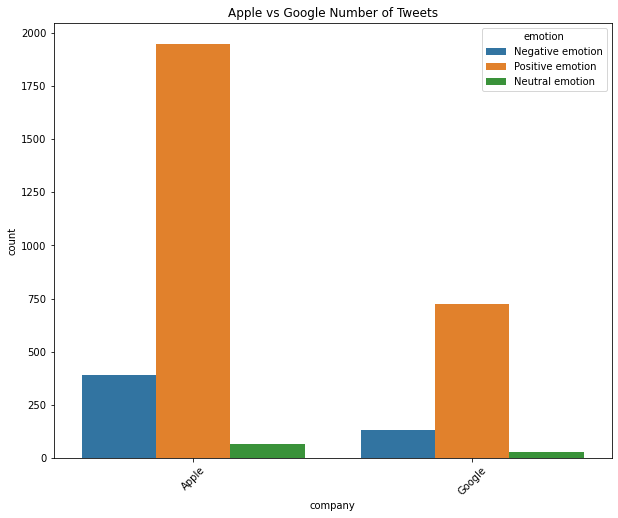

In [21]:
#counterplot of company with hue of emotion
plt.figure(figsize=(10,8))
sns.countplot(x="company", data=df, hue="emotion")
plt.xticks(rotation=45)
plt.title('Apple vs Google Number of Tweets')
plt.show()

**Noticed in the graph above Apple and Google has more Positive emotion than Negative or Neutral emotions and also Apple has more tweets than Google.** 

Target variable is 'emotion' by changing the 'Positive emotion','Neutral emotion' and 'Negative emotion' with '2','1' and '0' respectively to build out a multiclass classifier.

In [22]:
#replacing the emotion with classifier using lambda
df['emotion'] = df['emotion'].apply(lambda x : 2 if x == 'Positive emotion'
                                  else 1 if x == 'Neutral emotion' else 0)

In [23]:
df['emotion'].value_counts()

1    5388
2    2978
0     570
Name: emotion, dtype: int64

In [24]:
df.head()

,tweet_text,emotion_directed_at,emotion,company
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2,Google


In [25]:
#list of the stopwords in tweets
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',
           'apple', 'iphone', 'ipad', 'google', 'android', 'sxsw',
           '\'s', '2', 'rt']


In [26]:
#fuction to remove the non words
def remove_nonwords(string):
    return re.sub("[^A-Za-z ]\w*", ' ', string)

In [27]:
# we can define a function to process tweets
def process_tweet(tweet):
    tw = remove_nonwords(tweet)
    tokens = nltk.word_tokenize(tw)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [28]:
data = df['tweet_text']
target = df['emotion']

In [29]:
df_negative = df[df['emotion'] == 0]
df_neutral = df[df['emotion'] == 1]
df_positive = df[df['emotion'] == 2]

In [30]:
data_negative = df_negative['tweet_text']
data_neutral = df_neutral['tweet_text']
data_positive = df_positive['tweet_text']

In [31]:
pros_negative = list(map(process_tweet, data_negative))
pros_neutral = list(map(process_tweet, data_neutral))
pros_positive = list(map(process_tweet, data_positive))

In [32]:
flat_negative = [item for sublist in pros_negative for item in sublist]
flat_neutral = [item for sublist in pros_neutral for item in sublist]
flat_positive = [item for sublist in pros_positive for item in sublist]

In [33]:
negative_freq = FreqDist(flat_negative)
neutral_freq = FreqDist(flat_neutral)
positive_freq = FreqDist(flat_positive)

In [34]:
#top 15 most common words in negative emotion
negative_freq.most_common(15)

[('app', 60),
 ('store', 46),
 ('new', 43),
 ('like', 39),
 ('design', 29),
 ('people', 29),
 ('social', 27),
 ('apps', 26),
 ('need', 25),
 ('circles', 25),
 ('austin', 25),
 ('get', 24),
 ('one', 23),
 ('launch', 22),
 ('today', 21)]

In [35]:
#top 15 most common words in Neutral emotion
neutral_freq.most_common(15)

[('store', 867),
 ('new', 675),
 ('austin', 561),
 ('social', 476),
 ('launch', 459),
 ('today', 439),
 ('circles', 399),
 ('network', 354),
 ('app', 349),
 ('pop', 328),
 ('called', 275),
 ('line', 247),
 ('free', 240),
 ('major', 225),
 ('via', 221)]

In [36]:
#top 15 most common word in Positive emotion
positive_freq.most_common(15)

[('store', 544),
 ('app', 387),
 ('new', 357),
 ('austin', 256),
 ('pop', 204),
 ('launch', 159),
 ('get', 157),
 ('one', 147),
 ('great', 135),
 ('line', 131),
 ('party', 129),
 ('time', 128),
 ('social', 122),
 ('free', 116),
 ('cool', 116)]

In [37]:
# create counts of negative, neutral and positive with values and words
negative_bar_counts = [x[1] for x in negative_freq.most_common(30)]
negative_bar_words = [x[0] for x in negative_freq.most_common(30)]

neutral_bar_counts = [x[1] for x in neutral_freq.most_common(30)]
neutral_bar_words = [x[0] for x in neutral_freq.most_common(30)]

positive_bar_counts = [x[1] for x in positive_freq.most_common(30)]
positive_bar_words = [x[0] for x in positive_freq.most_common(30)]

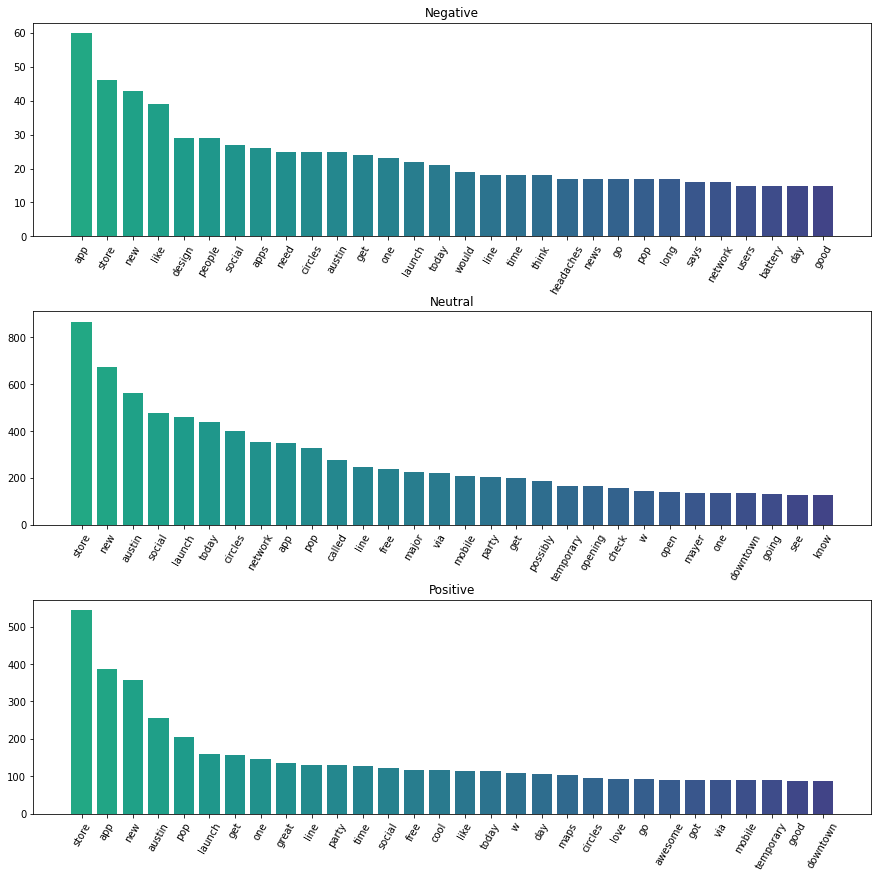

In [38]:
new_figure = plt.figure(figsize=(12,12))
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

ax = new_figure.add_subplot(311)
ax2 = new_figure.add_subplot(312)
ax3 = new_figure.add_subplot(313)

# Generate a line plot on first axes
ax.bar(negative_bar_words, negative_bar_counts, color= color)

# Draw a scatter plot on 2nd axes
ax2.bar(neutral_bar_words, neutral_bar_counts, color=color)

# Draw a scatter plot on 2nd axes
ax3.bar(positive_bar_words, positive_bar_counts, color=color)

ax.title.set_text('Negative')
ax2.title.set_text('Neutral')
ax3.title.set_text('Positive')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)
plt.show()

In [39]:
negative_dictionary = dict(zip(negative_bar_words, negative_bar_counts))
neutral_dictionary = dict(zip(neutral_bar_words, neutral_bar_counts))
positive_dictionary = dict(zip(positive_bar_words, positive_bar_counts))

In [40]:
# Creating fuction the word cloud:
def generate_wordcloud(data):
    wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(data)
    plt.figure(figsize=(10,10),facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

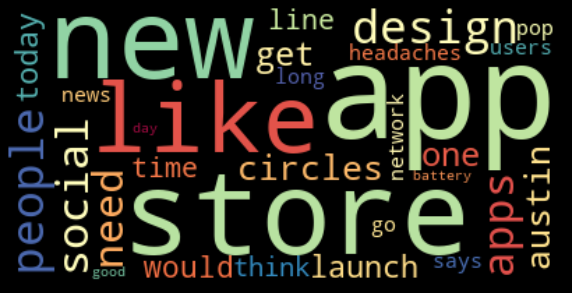

In [41]:
generate_wordcloud(negative_dictionary)

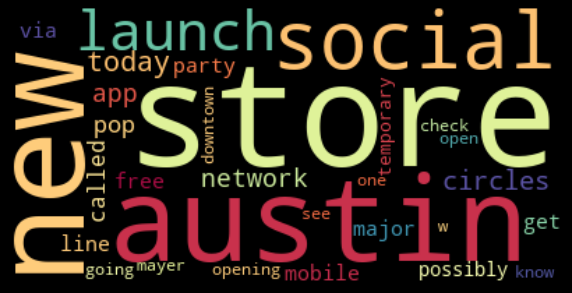

In [42]:
generate_wordcloud(neutral_dictionary)

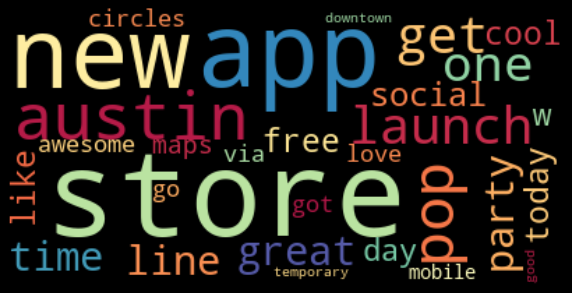

In [43]:
generate_wordcloud(positive_dictionary)

# Modeling the data

In [44]:
# applying the function to our data/features 
processed_data = list(map(process_tweet, data))

**Lemmatiztion of tweets**

In [45]:
#lemmatization of tweet_text
lemmatized_output = []
lemmatizer = WordNetLemmatizer() 
for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [46]:
lemmatized_output[:5]

['hr tweeting dead need upgrade plugin station',
 'know awesome app likely appreciate design also giving free t',
 'wait also sale',
 'hope year festival crashy year app',
 'great stuff fri marissa mayer tim book matt mullenweg']

In [47]:
X_lem = lemmatized_output
y_lem = target

# Vectorize the data

**Tfidf Vectorization (Term Frequency Inverse Document Frequency) of tweets**

In [48]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer()
# Fit the vectorizer
tfidff = tfidf.fit_transform(X_lem)
tfidf_df = pd.DataFrame(tfidff.toarray().transpose(), 
                            index = tfidf.get_feature_names()).transpose()
    

In [49]:
# Implement train/test split of dataset
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_df, y_lem, test_size=0.20, random_state=42)

# Base Model Logistic Regression 

In [50]:
lr_weighted = LogisticRegression()
lr_weighted.fit(X_train, y_train)

logreg_train_preds = lr_weighted.predict(X_train)
logreg_test_preds = lr_weighted.predict(X_test)

f1_train = metrics.f1_score(y_train, logreg_train_preds, average='weighted')
f1_test = metrics.f1_score(y_test, logreg_test_preds, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test, logreg_test_preds))
print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Test Accuracy score:  0.6789709172259508
Train F1 score:  0.7774263329701159
Test F1 score:  0.6431034507290109


In [51]:
# confusion matrix
confusion_matrix(y_test, logreg_test_preds)

array([[  5,  99,  22],
       [  3, 963, 128],
       [  1, 321, 246]], dtype=int64)

# Decision Tree Classifier

In [52]:
clf = DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train, y_train)

clf_train_preds= clf.predict(X_train)
clf_test_preds = clf.predict(X_test)

clf_f1_train = metrics.f1_score(y_train, clf_train_preds, average='weighted')
clf_f1_test = metrics.f1_score(y_test, clf_test_preds, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test, clf_test_preds))
print('Train F1 score: ', clf_f1_train)
print('Test F1 score: ', clf_f1_test)

Test Accuracy score:  0.610738255033557
Train F1 score:  0.9504907719838753
Test F1 score:  0.616397049457515


In [53]:
confusion_matrix(y_test, clf_test_preds)

array([[ 46,  40,  40],
       [ 65, 752, 277],
       [ 44, 230, 294]], dtype=int64)

# Random Forest Classifier

In [54]:
# Train the RandomForestClassifier model
rfc = RandomForestClassifier(random_state = 42,
                             n_estimators = 1000,
                             max_depth = 10,
                             class_weight = 'balanced',
                             verbose = 1)
rfc.fit(X_train, y_train)
rf_train_preds = rfc.predict(X_train)
rf_test_preds = rfc.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   58.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [55]:
rf_f1_train = metrics.f1_score(y_train, rf_train_preds, average='weighted')
rf_f1_test = metrics.f1_score(y_test, rf_test_preds, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test, rf_test_preds))
print('Train F1 score: ', rf_f1_train)
print('Test F1 score: ', rf_f1_test)

Test Accuracy score:  0.6012304250559284
Train F1 score:  0.7494530277323879
Test F1 score:  0.6092833937018606


In [56]:
confusion_matrix(y_test, rf_test_preds)

array([[ 41,  50,  35],
       [ 85, 719, 290],
       [ 40, 213, 315]], dtype=int64)

# Random Forest with GridSearch

In [62]:
# Parameter grid
grid = {
    'n_estimators': [30, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6 ],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}

gridsearch_rf_clf = GridSearchCV(rfc, grid, cv=3)
gridsearch_rf_clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   44.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   36.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   49.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   49.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=10, n_estimators=1000,
                                              random_state=42, verbose=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 6],
                         'min_samples_leaf': [1, 3, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [30, 100, 200]})

In [63]:
# The best combination of parameters in the grid
gridsearch_rf_clf.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [64]:
grid_rf_train_preds =gridsearch_rf_clf.predict(X_train)
grid_rf_test_preds = gridsearch_rf_clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


In [65]:
grid_rf_f1_train = metrics.f1_score(y_train, grid_rf_train_preds, average='weighted')
grid_rf_f1_test = metrics.f1_score(y_test, grid_rf_test_preds, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test, grid_rf_test_preds))
print('Train F1 score: ', grid_rf_f1_train)
print('Test F1 score: ', grid_rf_f1_test)

Test Accuracy score:  0.6812080536912751
Train F1 score:  0.9516114152614614
Test F1 score:  0.6606092550911791


# Naive Bayes Classifier

In [57]:
#initiate classifier
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB(alpha = 0.01)

In [58]:
nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

In [59]:
nb_f1_train = metrics.f1_score(y_train, nb_train_preds, average='weighted')
nb_f1_test = metrics.f1_score(y_test, nb_test_preds, average='weighted')
print('Test Accuracy score: ', metrics.accuracy_score(y_test, nb_test_preds))
print('Train F1 score: ', nb_f1_train)
print('Test F1 score: ', nb_f1_test)

Test Accuracy score:  0.6414988814317674
Train F1 score:  0.8651480128696383
Test F1 score:  0.6332466737267975


**confusion matrix and classification report**

In [60]:
confusion_matrix(y_test, nb_test_preds)

array([[ 32,  68,  26],
       [ 40, 842, 212],
       [ 17, 278, 273]], dtype=int64)

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

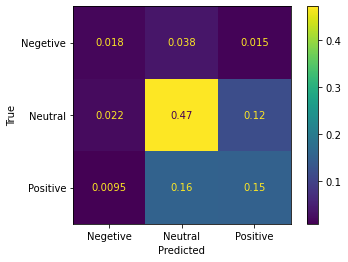

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix( y_test, nb_test_preds,normalize ='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Negetive','Neutral','Positive'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [63]:
from sklearn.metrics import classification_report
categories =['Negetive','Neutral','Positive']
print(classification_report(y_test, nb_test_preds,target_names=categories))

              precision    recall  f1-score   support

    Negetive       0.36      0.25      0.30       126
     Neutral       0.71      0.77      0.74      1094
    Positive       0.53      0.48      0.51       568

    accuracy                           0.64      1788
   macro avg       0.53      0.50      0.51      1788
weighted avg       0.63      0.64      0.63      1788



# Deep NLP With Word Embeddings

Using an Embedding Layer inside of a deep neural network to compute the word embedding <br>vectors on the tweets in the model.

In [64]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [65]:
from nltk import FreqDist, regexp_tokenize
# Pattern to capture words with apostrophes as one token
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

# Casting tweet_text to string or the tokenization doesn't work
df['tweet_text'] = df['tweet_text'].astype('str')

# Tokenizing tweets and inserting into df
df['raw_tokens'] = df['tweet_text'].map(lambda x: regexp_tokenize(x, pattern))

# Lowercase all tokens
df['raw_tokens'] = df['raw_tokens'].map(lambda x: [y.lower() for y in x])

In [66]:
#listing the stop words and creating a column in dataframe
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',
           'apple', 'iphone', 'ipad', 'google', 'android', 'sxsw',
           '\'s', '2', 'rt']
df['raw_tokens_stopped'] = df['raw_tokens'].map(lambda x: [y for y in x if y not in stopwords_list])

In [67]:
#tokenize and pad the sequence the tweets
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(df['raw_tokens_stopped']))
list_tokenized = tokenizer.texts_to_sequences(df['raw_tokens_stopped'])
X_values = sequence.pad_sequences(list_tokenized, maxlen=100)

In [74]:
y_values= pd.get_dummies(target).values

In [75]:
# Implement train/test split of dataset
X_train_tk, X_test_tk,y_train_tk,y_test_tk = train_test_split(X_values,y_values,
                                                            test_size=0.20,
                                                            random_state=42)

Constructing the neural network of a Sequential Model. In the embedding layer, by specifying the size of the<br> word vectors to be, as well as the size of the embedding space itself. The embedding size is 128, and<br> the size of the embedding space is best as the size of the total vocabulary but chose limited vocabulary size to 20000.<br>
Once the data has passed through an embedding layer,this data into an LSTM layer, followed by a Dense layer, <br>followed by output layer, added some Dropout layers after each of these layers, to help fight overfitting.<br>
Output layer is a Dense layer with 3 neurons, which corresponds to the 3 possible classes in the emotion and the <br>activation function for this output layer to 'softmax', so that the network will output a vector of predictions, <br>where each element's value corresponds to the percentage chance that the example is the class that corresponds to<br> that element, and where the sum of all elements in the output vector is 1. Compiled using important parameter <br>loss function to ('categorical_crossentropy', since this is a multiclass classification problem).

In [76]:
#Instantiate Sequential model
model = Sequential()

In [77]:
#constructing neutral network embedding layers
embedding_size = 128
model.add(Embedding(20000, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [78]:
#compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [79]:
#checking the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 25)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [80]:
#fitting the model on training data
history = model.fit(X_train_tk, y_train_tk, epochs=6, batch_size=32, validation_split=0.2)

Epoch 1/6
179/179 [==============================] - 15s 84ms/step - loss: 0.8963 - accuracy: 0.5820 - val_loss: 0.8174 - val_accuracy: 0.6049
Epoch 2/6
179/179 [==============================] - 10s 54ms/step - loss: 0.7979 - accuracy: 0.6280 - val_loss: 0.7623 - val_accuracy: 0.6636
Epoch 3/6
179/179 [==============================] - 14s 77ms/step - loss: 0.6626 - accuracy: 0.7375 - val_loss: 0.7777 - val_accuracy: 0.6692
Epoch 4/6
179/179 [==============================] - 10s 55ms/step - loss: 0.5356 - accuracy: 0.7928 - val_loss: 0.7913 - val_accuracy: 0.6818
Epoch 5/6
179/179 [==============================] - 14s 77ms/step - loss: 0.4076 - accuracy: 0.8452 - val_loss: 0.9183 - val_accuracy: 0.6559
Epoch 6/6
179/179 [==============================] - 10s 54ms/step - loss: 0.3347 - accuracy: 0.8814 - val_loss: 0.9328 - val_accuracy: 0.6734


In [81]:
#evaluating the score fo train and test data
train_score = model.evaluate(X_train_tk, y_train_tk)
test_score = model.evaluate(X_test_tk, y_test_tk)
print('Train score:', train_score)
print('Test Score:', test_score)

56/56 [==============================] - 1s 11ms/step - loss: 0.9689 - accuracy: 0.6555
Train score: [0.36424824595451355, 0.8704532980918884]
Test Score: [0.9689261317253113, 0.6554809808731079]


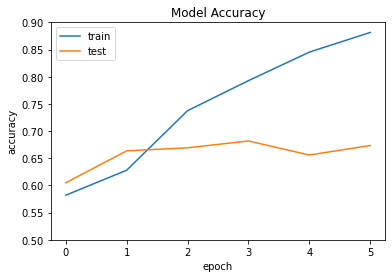

In [82]:
#plotting the Accuracy between training and test sets
import matplotlib.pyplot as plt
plt.ylim(0.5,0.9)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

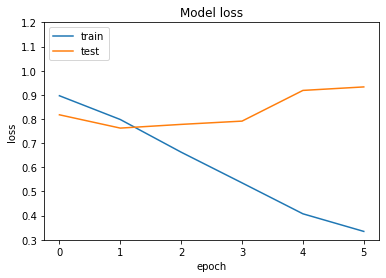

In [83]:
#plotting the loss between training and test sets
plt.ylim(0.3,1.2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**Making Predictions on Single instance**

In [85]:
tweet ='this phone and i am vey good  '
tokenizer.fit_on_texts(list(tweet))
list_tokenized1 = tokenizer.texts_to_sequences(tweet)
X_val = sequence.pad_sequences(list_tokenized1, maxlen=100)
model.predict(X_val)

array([[0.01001906, 0.80427915, 0.1857018 ],
       [0.00996159, 0.8047647 , 0.18527381],
       [0.01041305, 0.7049326 , 0.28465435],
       [0.00993766, 0.803124  , 0.1869383 ],
       [0.01001906, 0.80427915, 0.1857018 ],
       [0.01001906, 0.80427915, 0.1857018 ],
       [0.00996159, 0.8047647 , 0.18527381],
       [0.00862907, 0.83435726, 0.1570137 ],
       [0.10131203, 0.6829308 , 0.21575715],
       [0.00992676, 0.80296826, 0.18710499],
       [0.01001906, 0.80427915, 0.1857018 ],
       [0.01596534, 0.7015198 , 0.2825148 ],
       [0.10131203, 0.6829308 , 0.21575715],
       [0.00997616, 0.8036722 , 0.18635166],
       [0.01001906, 0.80427915, 0.1857018 ],
       [0.01041305, 0.7049326 , 0.28465435],
       [0.01001906, 0.80427915, 0.1857018 ],
       [0.01596534, 0.7015198 , 0.2825148 ],
       [0.01001906, 0.80427915, 0.1857018 ],
       [0.01001906, 0.80427915, 0.1857018 ],
       [0.0105632 , 0.7996586 , 0.18977825],
       [0.00992676, 0.80296826, 0.18710499],
       [0.

# Conclusion

Performed different models on the data, such as Logistic Regression, Decision Tree, Random Forest, <br>Random Forest with GridSearch and Naive Bayes classifiers, all models got 60% or less than 70% of accuracy<br> and F1-Score of training set is nearly 20% more than the test set which seems overfitting.
Built a deep neural<br> network with Word Embeddings layers any Accuracy of Train set is 87% and loss function is 0.36 and<br> Accuracy of test set is 66% and loss function is 0.97,  the difference of loss function is more than twice, even<br> this model is also overfitted.